In [21]:
import numpy as np 
import pandas as pd 
import pymc3 as pm 
import matplotlib.pyplot as plt 
import arviz 
import pickle


bd = pd.read_csv('./numpyro/birthdays.txt')

lam_date_join = lambda row: f"{row['year']}-{row['month']}-{row['day']}"
bd["date"] = pd.to_datetime(bd.apply(lam_date_join, axis=1), format="%Y-%m-%d")

lam_get_day = lambda date: date.days

bd_sm = bd#[bd["year"] <= 1970]
bd_sm['date_indexed'] = (bd_sm['date'] - bd_sm['date'].min()).apply(lam_get_day)
# bd_sm['date_normed'] = (bd_sm['date_indexed'] - bd_sm['date_indexed'].mean()) / bd_sm['date_indexed'].std()
bd_sm['births_normed'] = (bd_sm['births'] - bd_sm['births'].mean()) / bd_sm['births'].std()

# date_scale = 1/bd_sm['date_indexed'].std() # one day corresps to date_scale normed days

bd_sm['date_normed'] = bd_sm['date_indexed']
# bd_sm['births_normed'] = bd_sm['births']


# add in the special days

# get the day of the week (used for some holidays)
n_weeks = int(np.ceil(bd_sm.shape[0] / 7))
bd_sm["weekdays"] = pd.Series(["Wed","Thr","Fri","Sat","Sun","Mon","Tue"] * n_weeks)

def find_holiday(df: pd.DataFrame, month: int, weekday: str, n: int):
    """
        Get indicator column for holiday which occurs on
        n-th weekday of month. (n=-1 for last)
    """
    indic = pd.Series(0, df.index) 
    hols = df.query(f"month == {month} and weekdays == '{weekday}'").groupby(by=['year']).nth(n=n)
    for j in range(hols.shape[0]): # for each one...
        j_date = hols.iloc[j]["date"] # ...get the date...
        indic[df["date"]==j_date] = 1 # ...and record it

    return indic

bd_sm["spd_newyears"] = ((bd_sm["month"] == 1) & (bd_sm["day"] == 1)).astype(int)
bd_sm["spd_val"] = ((bd_sm["month"] == 2) & (bd_sm["day"] == 14)).astype(int)
bd_sm["spd_leap"] = ((bd_sm["month"] == 2) & (bd_sm["day"] == 29)).astype(int)
bd_sm["spd_aprilf"] = ((bd_sm["month"] == 4) & (bd_sm["day"] == 1)).astype(int)
bd_sm["spd_memorial"] = find_holiday(bd_sm, month=5, weekday='Mon', n=-1) 
bd_sm["spd_indep"] = ((bd_sm["month"] == 7) & (bd_sm["day"] == 4)).astype(int)
bd_sm["spd_labor"] = find_holiday(bd_sm, month=9, weekday='Mon', n=0) 
bd_sm["spd_halloween"] = ((bd_sm["month"] == 10) & (bd_sm["day"] == 31)).astype(int)
bd_sm["spd_thanks"] = find_holiday(bd_sm, month=11, weekday='Thr', n=3)
bd_sm["spd_xmas"] = ((bd_sm["month"] == 12) & (bd_sm["day"] == 25)).astype(int)


# X = bd_sm['date_normed'].values[:300,None]
# y = bd_sm['births_normed'].values[:300,None]

# X = bd_sm[['date_normed', 'spd_newyears', 'spd_val', 'spd_leap', 'spd_aprilf',
#     'spd_memorial','spd_indep','spd_labor','spd_halloween','spd_thanks',
#     'spd_xmas']].values[:,:]
# y = bd_sm['births_normed'].values[:,None]

df = bd_sm[['date','births_normed']]
df=df.rename(mapper={'date':'ds', 'births_normed':'y'}, axis=1)

In [26]:
from fbprophet import Prophet

nt = int(df.shape[0] * .8)

m = Prophet()
m.fit(df.iloc[:nt,:])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


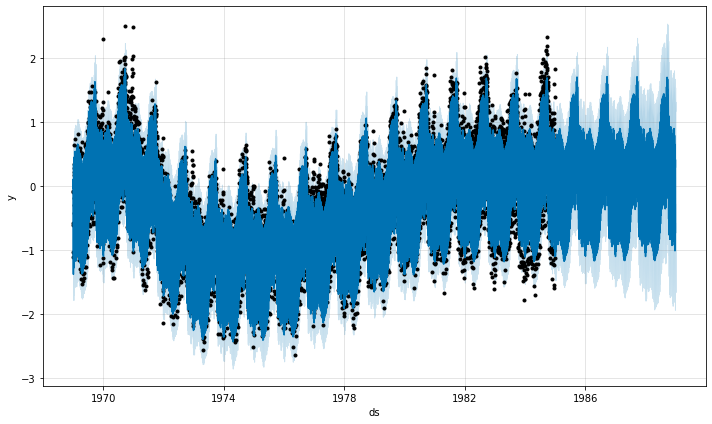

In [28]:
forecast = m.predict(df.iloc[:])
fig1 = m.plot(forecast)

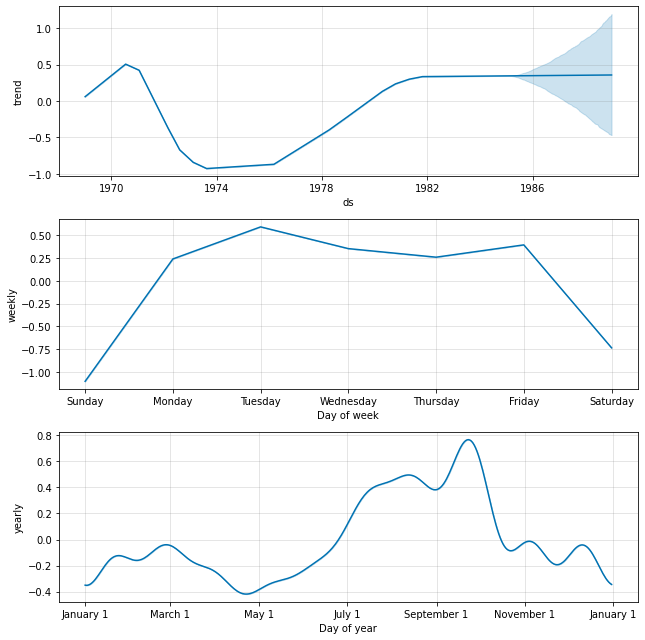

In [29]:
fig2 = m.plot_components(forecast)